In [1]:
# Proyecto final de Análisis de datos atmosféricos.
# ICACC - UNAM - maestría.
# 2 de diciembre de 2021.

import pandas as pd
import numpy as np

from scipy import stats

from matplotlib import pyplot as plt

from statsmodels.tools.tools import add_constant
from statsmodels.stats.diagnostic import lilliefors

var_2 = "Usuarios"
var = "Consumo"

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
path = "/content/drive/MyDrive/Colab/Subsidio_electricidad/"
path_data = path + "data/Actual/data_yearly.csv"

path_r = path + "/Graficas"

df = pd.read_csv( path_data )
df = df.where(df.notna(), 0)

# Unimos las tarifas 1 y DAC.
df.rename( columns = {"Consumo_1*": "Consumo",
    "Usuarios_1*": "Usuarios"}, inplace = True )
df["Consumo"] += df["Consumo_DAC"]
df["Usuarios"] += df["Usuarios_DAC"]
df.drop(["Consumo_DAC", "Usuarios_DAC"],
    axis = 1, inplace = True)
#df["Consumo"] /= df["Usuarios"]
df = df[df["Tarifa"] == "1"]

# Variables dummy
#df = pd.concat([df, pd.get_dummies(
#    df["Tarifa"], prefix = "tar", drop_first = True
#    ) ], axis = 1)
#df = pd.concat([df, pd.get_dummies(
#    df["CVE_ENT"], prefix = "ent", drop_first = True
#    ) ], axis = 1)
#df = pd.concat([df, pd.get_dummies(
#    df["CVE_INEGI"], prefix = "mun", drop_first = True
#    ) ], axis = 1)
#df["2016"] = df["Año"].where(df["Año"] == 2016, 0)
#df["2016"] = df["2016"].where(df["2016"] != 2016, 1)

# Valores anómalos.
print(df.loc[1947, "NOM_MUN"])
print(df.loc[7491, "NOM_MUN"])
print(df.loc[7302, "NOM_MUN"])
print(df.loc[11258, "NOM_MUN"])
df.drop(
    [ 11257, 11258, 11259, 11260, 11261, 11262, 11263,
      7301, 7302, 7303, 7304, 7305, 7306, 7307,
      7490, 7491, 7492, 7493, 7494, 7495, 7496
    , 1946, 1947, 1948, 1949, 1950, 1951, 1952
    ], inplace = True)

# Eliminamos las variables no numéricas.
df = df.drop(columns = [ var_2,
    "CVE_MUN", "NOM_ENT", "NOM_MUN",
    "$luz", "M_verano", "Tmean_max_2"
    , "CVE_ENT", "Tarifa", "CVE_INEGI",
    ] )


Iztapalapa
Natividad
Guelatao de JuÃ¡rez
Coatepec


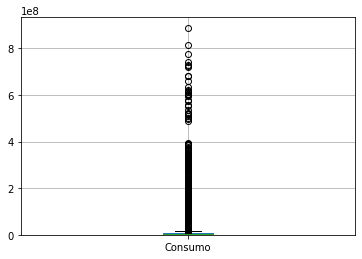

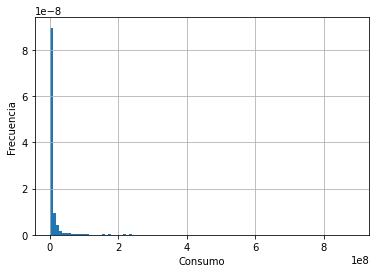

In [ ]:
# Datos sin transformar.

# Boxplot.
fig, ax = plt.subplots()
df.boxplot(column = var, ax = ax)

ax.set_ylim(0)

fig.savefig(path_r + "boxplot_sin_transformar.png")

# Histograma.
fig, ax = plt.subplots()
df[var].hist(bins = 100, ax = ax, density = True)

ax.set_xlabel(var)
ax.set_ylabel("Frecuencia")

fig.savefig(path_r + "histograma_sin_transformar.png")

In [ ]:
df[var].describe()

count    1.025500e+04
mean     1.391574e+07
std      5.134055e+07
min      2.398000e+04
25%      6.034470e+05
50%      2.336321e+06
75%      6.933942e+06
max      8.886183e+08
Name: Consumo, dtype: float64

In [ ]:
print(f"skew: {df[var].skew()}")
print(f"curtosis: {df[var].kurtosis()}")

skew: 8.096907173495795
curtosis: 82.88055287646925



Lilliefors
n   : 10255
D_s : 0.028
crit: 0.009
alpha: 40.05
loc  : 3.28
beta : 0.28


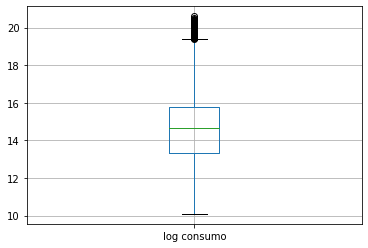

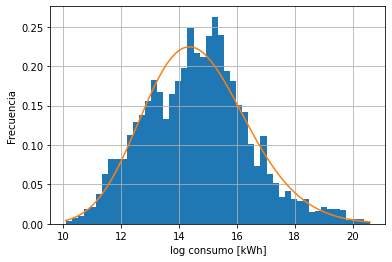

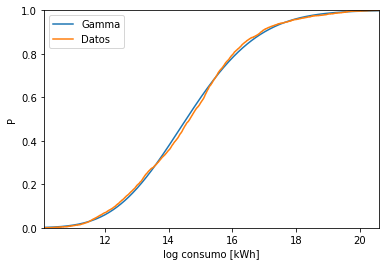

In [ ]:
# Datos transformados.

df_2 = df.copy()
df_2[var] = np.log(df[var])

# Boxplot.
fig, ax = plt.subplots()
df_2.boxplot(column = var, ax = ax)

ax.set_xticklabels( ["log consumo"] )

fig.savefig(path_r + "boxplot_log.png")

# Histograma con distribuciones.
fig, ax = plt.subplots()
df_2[var].hist(bins = 50, ax = ax, density = True)

#loc, scale = stats.logistic.fit(df_2[var])
#x = np.linspace(df_2[var].min(), df_2[var].max(), 1000)
#logistic = stats.logistic.pdf(x, loc, scale)
#ax.plot(x, logistic)

alpha, loc, beta = stats.gamma.fit(df_2[var])
x = np.linspace(df_2[var].min(), df_2[var].max(), 1000)
gamma = stats.gamma.pdf(x, alpha, loc, beta)
ax.plot(x, gamma)

ax.set_xlabel("log consumo [kWh]")
ax.set_ylabel("Frecuencia")

fig.savefig(path_r + "histograma_log.png")

# Lilliefors
# Prueba Kolmogorov-Smirnov.

# Tamaño de la muestra.
n = df_2[var].shape[0]

# Frecuencia acumulada.
# Criterio de Weibull.
F = ( np.arange( 1, n + 1 ) /
    np.float64( n + 1 ) )

# Frecuencia acumulada de
# distribución normal.
x = df_2[var].sort_values()
F_n = stats.gamma.cdf(
    x, alpha, loc, beta )

# Lilliefors critical value.
crit = 0.886 / np.sqrt(n)
# Automático.
# Smirnov test statistic.
D = np.abs( F - F_n )
D_s = D.max()

print("")
print("Lilliefors")
print(f"n   : {n}")
print(f"D_s : {D_s:.3f}")
print(f"crit: {crit:.3f}")

# Graficamos las distribuciones.
x_n = np.linspace( df_2[var].min(),
    df_2[var].max(), 1000 )
#y_n = stats.logistic.cdf( x_n, loc, scale )
y_n = stats.gamma.cdf( x_n, alpha, loc, beta )

fig, ax = plt.subplots()
ax.plot(x_n, y_n)

# Grficamos la frecuencia acumulada.
ax.plot(df_2[var].sort_values(),
    F, drawstyle = "steps")

ax.set_xlabel("log consumo [kWh]")
ax.set_ylabel("P")
ax.legend(["Gamma",
    "Datos", "Intervalo de\nconfianza"])
ax.set_xlim( df_2[var].min(), df_2[var].max() )
ax.set_ylim(0, 1)

print(f"alpha: {alpha:.2f}")
print(f"loc  : {loc:.2f}")
print(f"beta : {beta:.2f}")

fig.savefig(path_r + "kolmogorov_log.png")

In [ ]:
df_2[var].describe()

count    10255.000000
mean        14.646919
std          1.793517
min         10.084975
25%         13.310413
50%         14.664088
75%         15.751939
max         20.605178
Name: Consumo, dtype: float64

In [ ]:
print(f"skew: {df_2[var].skew()}")
print(f"curtosis: {df_2[var].kurtosis()}")

skew: 0.2804394826323087
curtosis: 0.03306070495235014


In [ ]:
# Prueba chi cuadrada.

n_obs, bins = np.histogram( 
    df_2[var], bins = 50)

#loc, scale = stats.logistic.fit(df_2[var])
#def dist(x):
#    y = stats.logistic.cdf(x, loc, scale)
#    return y

alpha, loc, beta = stats.gamma.fit(df_2[var])
def dist(x):
    y = stats.gamma.cdf(x, alpha, loc, beta)
    return y

#alpha, loc, beta = stats.weibull_min.fit(df_2[var])
#def dist(x):
#    y = stats.weibull_min.cdf(x, alpha, loc, beta)
#    return y

#mu, sigma = stats.norm.fit(df_2[var])
#def dist(x):
#    y = stats.norm.cdf(x, mu, sigma)
#    return y

# Número de parámetros.
params = 3

# Discretizamos la distribución normal.
prob = [dist(bins[1])]
for i in range(2, len(bins) - 1):
    prob.append( dist(bins[i]) - dist(bins[i - 1]) )
prob.append( 1 - dist(bins[-1] ) )
prob = np.array(prob)
n_dist = n_obs.sum() * prob

# Prueba chi-square.
alpha_test = 0.05
clases = bins.shape[0] - 1
nu = clases - params - 1
crit = stats.chi.ppf(1 - alpha_test, nu)

# Automática.
chi_test = stats.chisquare(
    n_obs, n_dist, ddof = params)
chi = chi_test.statistic
p = chi_test.pvalue

print("")
print("Chi-square")
print(f"Chi : {chi:.2f}")
print(f"p   : {p:.4f}")
print(f"crit: {crit:.4f}")


Chi-square
Chi : 431.24
p   : 0.0000
crit: 7.9265


In [ ]:
# Selección hacia adelante.

# Sistema.
df_2 = df.copy()

# Features.
x = df_2.iloc[:, 1:19].copy()
#x.drop(columns = "Area", inplace = True)
#x.drop(columns = "lon", inplace = True)
#x.drop(columns = "lat", inplace = True)
#x.drop(columns = "PIB", inplace = True)

x["HDD_mean"] = np.log(  - x["HDD_mean"]     )
x["CDD_mean"] = np.log(    x["CDD_mean"]     )
x["PCI"] = np.log( x["PCI"] )
x["Densidad_poblacion"] = np.log(
    x["Densidad_poblacion"] )

# Predictando.
y = np.log(df_2[var])
YY = np.array([y]).T

# Variables para la tabla final.
n = x.shape[1]
x_j = []
R_j = []
F_j = []
p_F = []
names = []
J_j = []
p_J = []

# Evaluamos 10 variables.
for p in range(10):

    R = []
    F = []
    res = []
    jarque = []
    p_jarq = []

    # Ajustamos una variable a la vez.
    for i in range(x.shape[1]):

        # Regresión lineal
        x_i = x.iloc[:, i]
        #XX = add_constant(x_i)
        XX = np.ones_like([x_i]).T
        if len(x_j) != 0:
            for j in range( len(x_j) ):
                XX = np.concatenate( 
                  ( XX, np.array( [x_j[j]] ).T ),
                  axis = 1 )
        
        XX = np.concatenate( 
            ( XX, np.array( [x_i] ).T ),
            axis = 1 )
        
        XX_sq = XX.T @ XX
        XX_inv = np.linalg.inv(XX_sq)
        BB = XX_inv @ ( XX.T @ YY )
        
        y_reg = ( XX @ BB )[:,0]

        # Cantidad de predictores.
        k = len(x_j) + 1

        # ANOVA
        SST = ( ( y - y.mean() ) ** 2 ).sum()
        res = y_reg - y
        SSE = ( res ** 2 ).sum()
        Se = np.sqrt( SSE / ( y.shape[0] - k - 1 ) )
        R.append( 1 - SSE / SST )
        F.append( ( SST - SSE ) / ( Se ** 2 * k ) )
        jarque.append( stats.jarque_bera(res)[0] )
        p_jarq.append( stats.jarque_bera(res)[1] )
    
    # Seleccionamos la variable con mayor R.
    R_j.append( max( R ) )
    ind = R.index( R_j[-1] )
    F_j.append( F[ ind ] )
    p_F.append( stats.f.cdf( F_j[-1],
        y.shape[0] - k - 1, k ) )
    x_j.append( x.iloc[ : , ind ] )
    names.append( x_j[-1].name )
    J_j.append( jarque[ ind ] )
    p_J.append( p_jarq[ ind ] )

    x.drop(columns = names[-1], inplace = True)

# Resultados.
result = pd.DataFrame( [ names, R_j, F_j,
     p_F, J_j, p_J ] ).transpose()
result.rename( columns = {
    0: "Variable", 1: "R", 2: "F",
    3:"p_F", 4: "Jarque-Bera", 5: "p_J"
    }, inplace = True )
result.index.rename("Iteracion", inplace = True)
result.index += 1

result

,Variable,R,F,p_F,Jarque-Bera,p_J
Iteracion,,,,,,
1,PCI,0.463076,8842.81,0.991516,96.2116,0
2,Poblacion,0.606482,7900.1,0.999873,73.9754,1.11022e-16
3,Densidad_poblacion,0.668062,6877.08,0.999998,35.8117,1.67336e-08
4,lat,0.71252,6351.16,1,61.0364,5.57332e-14
5,Area,0.728159,5490.63,1,130.711,0
6,PIB,0.735377,4746.47,1,267.422,0
7,CDD_p90,0.739661,4159.03,1,212.396,0
8,Tmax,0.743518,3712.78,1,184.306,0
9,lon,0.746311,3348.78,1,186.984,0


In [ ]:
# Selección hacia atrás con minimización de Jarque-Bera.

df_2 = df.copy()

# Features.
x = df_2.iloc[:, 1:19].copy()
x["HDD_mean"] = np.log(  - x["HDD_mean"]     )
x["CDD_mean"] = np.log(    x["CDD_mean"]     )
x["PCI"] = np.log( x["PCI"] )
x["Densidad_poblacion"] = np.log(
    x["Densidad_poblacion"] )

# Predictando.
y = np.log(df_2[var])
YY = np.array([y]).T

# Variables para la tabla final.
n = x.shape[1]
x_j = []
R_j = []
F_j = []
p_F = []
names = []
J_j = []
p_J = []

x_j.append(x["PCI"])
x.drop(columns = "PCI", inplace = True)
x_j.append(x["Poblacion"])
x.drop(columns = "Poblacion", inplace = True)
q = 2
# Evaluamos 3 variables.
for p in range(4):

    R = []
    F = []
    res = []
    jarque = []
    p_jarq = []

    # Ajustamos una variable a la vez.
    for i in range(x.shape[1]):

        # Regresión lineal
        x_i = x.iloc[:, i]
        #XX = add_constant(x_i)
        XX = np.ones_like([x_i]).T
        if len(x_j) != 0:
            for j in range( len(x_j) ):
                XX = np.concatenate( 
                  ( XX, np.array( [x_j[j]] ).T ),
                  axis = 1 )
        
        XX = np.concatenate( 
            ( XX, np.array( [x_i] ).T ),
            axis = 1 )
        XX_2 = XX.copy()
        
        XX_sq = XX.T @ XX
        XX_inv = np.linalg.inv(XX_sq)
        BB = XX_inv @ ( XX.T @ YY )
        
        y_reg = ( XX @ BB )[:,0]

        # Cantidad de predictores.
        k = len(x_j) + 1 + q

        # ANOVA
        SST = ( ( y - y.mean() ) ** 2 ).sum()
        res = y_reg - y
        SSE = ( res ** 2 ).sum()
        Se = np.sqrt( SSE / ( y.shape[0] - k - 1 ) )
        R.append( 1 - SSE / SST )
        F.append( ( SST - SSE ) / ( Se ** 2 * k ) )
        jarque.append( stats.jarque_bera(res)[0] )
        p_jarq.append( stats.jarque_bera(res)[1] )
    
    # Seleccionamos la variable con menor Jarque Bera.
    J_j.append( min( jarque ) )
    ind = jarque.index( J_j[-1] )
    p_J.append( p_jarq[ind] )
    R_j.append( R[ind] )
    F_j.append( R[ind] )
    p_F.append( stats.f.cdf( F_j[-1],
        y.shape[0] - k - 1, k ) )
    x_j.append( x.iloc[ : , ind ] )
    names.append( x_j[-1].name )

    x.drop(columns = names[-1], inplace = True)

result = pd.DataFrame( [ names, R_j,
    #F_j, p_F, 
    J_j, p_J ] ).transpose()
result.rename( columns = {
    0: "Variable", 1: "R"
    #, 2: "F", 3:"p_F"
    , 2: "Jarque-Bera", 3: "p_J"
    }, inplace = True )
result.index.rename("Iteración", inplace = True)
result.index += ( 1 )#+ q )

result

,Variable,R,Jarque-Bera,p_J
Iteración,,,,
1,Densidad_poblacion,0.668062,35.8117,1.67336e-08
2,CDD_mean,0.695769,5.67374,0.0586089
3,Pre_Tmean,0.701618,0.961647,0.618274
4,CDD_p90,0.702864,0.27843,0.870041


In [ ]:
# Regresión final.

df_2 = df.copy()

# Regresión lineal

# Features.
x = df_2[ ["PCI"
    , "Poblacion"
    , "Densidad_poblacion"
    , "CDD_mean"
    , "Pre_Tmean"
    #, "PIB"
    #, "Año"
    ] ].copy()
x["CDD_mean"] = np.log(    x["CDD_mean"]     )
x["PCI"] = np.log( x["PCI"] )
x["Densidad_poblacion"] = np.log(
    x["Densidad_poblacion"] )

# Predictando.
y = np.log(df_2[var])
YY = np.array([y]).T

x = add_constant(x)
XX = x.values

XX_sq = XX.T @ XX
XX_inv = np.linalg.inv(XX_sq)
BB = XX_inv @ ( XX.T @ YY )
        
# Y gorro.
y_reg = ( XX @ BB )[:,0]
y_reg_2 = y_reg.copy()

# Cantidad de predictores.
k = x.shape[1]

res = y_reg - y
SST = ( ( y - y.mean() ) ** 2 ).sum()
SSE = ( res ** 2 ).sum()
Se = np.sqrt( SSE / ( y.shape[0] - k - 1 ) )
R =  1 - SSE / SST
F = ( SST - SSE ) / ( Se ** 2 * k )

print(f"            F: {F:.2f}")
print(f"            R: {R:.5f}")
print(f"  Jarque-Bera: {stats.jarque_bera(res)}")

            F: 4016.20
            R: 0.70162
  Jarque-Bera: (0.9616465339543873, 0.6182741775120482)


Filliben Q-Q plot test: 0.9997
mu: -1.2430721710116826e-12
mu: 0.9796493065429063


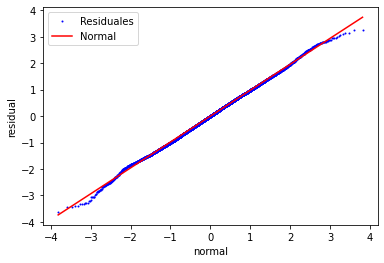

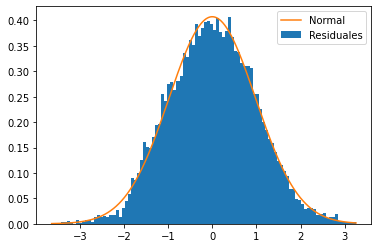

In [ ]:
# Q-Q plot
fig, ax = plt.subplots()
qqplot = stats.probplot(res, plot = ax)
ax.get_lines()[0].set_markersize(1)

ax.set_title(None)
ax.set_xlabel("normal")
ax.set_ylabel("residual")
ax.legend(["Residuales", "Normal"])

fig.savefig(path_r + "QQ_plot.png")

print(f"Filliben Q-Q plot test: {qqplot[1][2]:.4f}")

fig, ax = plt.subplots()
ax.hist(res, bins = 100, density = True)

mu, sigma = stats.norm.fit(res)
x = np.linspace(res.min(), res.max(), 1000)
norm = stats.norm.pdf(x, mu, sigma)
ax.plot(x, norm)

ax.legend(["Normal", "Residuales"])

fig.savefig(path_r + "histograma_res.png")

print(f"mu: {mu}")
print(f"mu: {sigma}")

In [ ]:
# Valores anómalos

res.sort_values().head(40).index

Int64Index([ 933,  935, 1255,  937,  932,  934,  755, 1371,  968,  931, 1370,
            1254, 1257, 5427, 1253, 1256,  754,  967,  936, 1342,  856, 1259,
             730,  996, 1258, 2816, 2817,  994,  998,  969,  995,  997,  970,
            2818,  855, 2814,  729, 1367,  733,  751],
           dtype='int64')